In [2]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings

# Configure matplotlib for inline plotting and use ggplot style
%matplotlib inline 
plt.style.use('ggplot')

# Set TensorFlow logger level to avoid unnecessary output
tf.get_logger().setLevel('ERROR')

# Suppress warnings
warnings.filterwarnings('ignore')

# Display TensorFlow version to confirm compatibility
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


In [3]:
df = pd.read_csv(r'data\btc.csv')

In [4]:
df.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
0,5/26/2018,BTCUSD,7459.11,7640.46,7380.00,7520.00,2722.80,2.042265e+07
1,5/25/2018,BTCUSD,7584.15,7661.85,7326.94,7459.11,8491.93,6.342069e+07
2,5/24/2018,BTCUSD,7505.00,7734.99,7269.00,7584.15,11033.72,8.293137e+07
3,5/23/2018,BTCUSD,7987.70,8030.00,7433.19,7505.00,14905.99,1.148104e+08
4,5/22/2018,BTCUSD,8393.44,8400.00,7950.00,7987.70,6589.43,5.389753e+07


In [5]:
data = df['Close'].values

In [6]:
type(data)

numpy.ndarray

In [7]:
data.shape

(1273,)

# Standardizing the data and bringing it to same scale

In [8]:
scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1 , 1))


# Plotting the graph

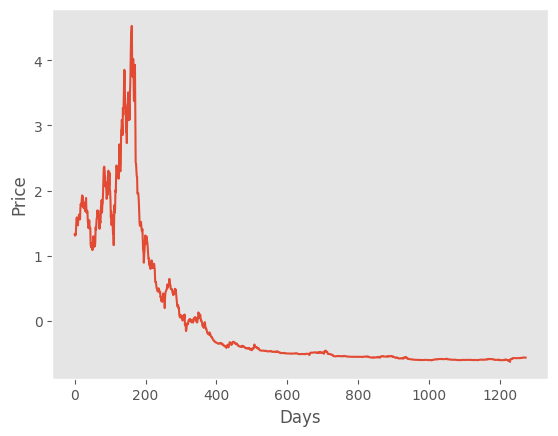

In [9]:
plt.plot(data)
plt.xlabel('Days')
plt.ylabel('Price')
plt.grid()

# We define a function called get_data which generates the input and output. It takes the data and window_size as an input and generates the input and target column.

In [10]:
def get_data(data, window_size):
    X = []
    y = []
    
    i = 0
    
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

In [11]:
X, y = get_data(data, window_size = 7)
#train set
X_train  = np.array(X[:1000])
y_train = np.array(y[:1000])

#test set
X_test = np.array(X[1000:])
y_test = np.array(y[1000:])

In [12]:

X_train.shape

(1000, 7, 1)

# Defining the parameter

In [13]:
batch_size = 7
window_size = 7 
hidden_layer = 256 
learning_rate = 0.001 

In [14]:
# Defining the placeholders for our input and output
tf.compat.v1.disable_v2_behavior()

# Placeholder

In [15]:
input = tf.compat.v1.placeholder(tf.float32 , shape=[batch_size, window_size , 1 ])

target = tf.compat.v1.placeholder(tf.float32 , [batch_size , 1])

# Weights

In [16]:
# Input gate Weights : 
U_i = tf.Variable(tf.compat.v1.truncated_normal(shape=[1 , hidden_layer] , stddev=0.05)) # Input_size = 1 as each element in the sequence has only 1 feature
W_i = tf.Variable(tf.compat.v1.truncated_normal(shape= [hidden_layer , hidden_layer] , stddev= 0.05))
b_i = tf.Variable(tf.compat.v1.zeros([hidden_layer]))

In [17]:
# Forget gate Weights

U_f = tf.Variable(tf.compat.v1.truncated_normal(shape=[1 , hidden_layer] , stddev=0.05))
W_f = tf.Variable(tf.compat.v1.truncated_normal(shape=[hidden_layer , hidden_layer] , stddev= 0.05))
b_f = tf.Variable(tf.compat.v1.zeros(shape=[hidden_layer]))

In [18]:
# Output gate weights

U_o = tf.Variable(tf.compat.v1.truncated_normal([1, hidden_layer], stddev=0.05))
W_o = tf.Variable(tf.compat.v1.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_o = tf.Variable(tf.compat.v1.zeros([hidden_layer]))

In [19]:
# Candidate state weights
U_g = tf.Variable(tf.compat.v1.truncated_normal([1, hidden_layer], stddev=0.05))
W_g = tf.Variable(tf.compat.v1.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_g = tf.Variable(tf.compat.v1.zeros([hidden_layer]))

In [20]:
V = tf.Variable(tf.compat.v1.truncated_normal(shape=[hidden_layer , 1] ,stddev=0.05))
b_v = tf.Variable(tf.compat.v1.zeros([1]))

# Defining LSTM Cell

In [21]:
def LSTM_cell (input , prev_hidden_state , prev_cell_state):
  
  it = tf.sigmoid(tf.matmul(input , U_i) + tf.matmul(prev_hidden_state , W_i) + b_i)

  ft = tf.sigmoid(tf.matmul(input , U_f) + tf.matmul(prev_hidden_state , W_f) + b_f)

  ot = tf.sigmoid(tf.matmul(input , U_o) + tf.matmul(prev_hidden_state , W_o) + b_o)

  gt = tf.tanh(tf.matmul(input , U_g) + tf.matmul(prev_hidden_state , W_g) + b_g)

  ct = (prev_cell_state * ft) + (it * gt)

  ht = ot * tf.tanh(ct)

  return ct , ht 

In [22]:
y_hat = []

for i in range(batch_size):
  
  hidden_state = np.zeros([1 , hidden_layer] , dtype=np.float32)
  cell_state = np.zeros ([1 , hidden_layer] , dtype=np.float32)

  for t in range(window_size):
    
    cell_state , hidden_state = LSTM_cell(tf.reshape(input[i][t] , (-1 , 1)) , hidden_state , cell_state)

  y_hat.append(tf.matmul(hidden_state , V) + b_v)

In [23]:
# back propagation
losses = []

for i in range(len(y_hat)):
    losses.append(tf.reduce_mean(tf.square(tf.reshape(target[i], (-1, 1)) -  y_hat[i])))

# Calculate the average loss across all time steps
loss = tf.reduce_mean(losses)

In [24]:
# gradient clipping is done to avoid exploding gradient problem
gradients = tf.gradients(loss, tf.compat.v1.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, 4.0)

# adam optimizer

In [25]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).apply_gradients(zip(gradients,
tf.compat.v1.trainable_variables()))

# training the LSTM Model

In [26]:
session = tf.compat.v1.Session()
session.run(tf.compat.v1.global_variables_initializer())
epochs = 100

for i in range(epochs):
    train_predictions = []
    index = 0
    epoch_loss = []
    
    #Sample some batche of data and train the network
    while(index + batch_size) <= len(X_train):
        
        #sample batch of data
        X_batch = X_train[index:index+batch_size]
        y_batch = y_train[index:index+batch_size]
        
        #predict the prices and compute loss
        predicted, loss_val, _ = session.run([y_hat, loss, optimizer], feed_dict={input:X_batch, target:y_batch})
        
        #store the loss
        epoch_loss.append(loss_val)
        
        #store the predictions
        train_predictions.append(predicted)
        index += batch_size
        
        
    #print the loss on every 10 iterations
    if (i % 10)== 0:
        print (f'Epoch {i}, Loss: {np.mean(epoch_loss)}')
        


Epoch 0, Loss: 0.1918371468782425
Epoch 10, Loss: 0.04696519300341606
Epoch 20, Loss: 0.030483558773994446
Epoch 30, Loss: 0.0189079400151968
Epoch 40, Loss: 0.012338767759501934
Epoch 50, Loss: 0.00974834430962801
Epoch 60, Loss: 0.010886460542678833
Epoch 70, Loss: 0.00975913554430008
Epoch 80, Loss: 0.00857559684664011
Epoch 90, Loss: 0.00803240854293108


# Making prediction using LSTM

In [27]:
predicted_output = []

i = 0 

while i + batch_size <= len(X_test):

 output = session.run([y_hat] , feed_dict={input : X_test[i:i + batch_size]})
 i += batch_size
 predicted_output.append(output)



In [28]:
predicted_output[0]

[[array([[-0.6034889]], dtype=float32),
  array([[-0.6006866]], dtype=float32),
  array([[-0.5995649]], dtype=float32),
  array([[-0.5990119]], dtype=float32),
  array([[-0.5983683]], dtype=float32),
  array([[-0.6000026]], dtype=float32),
  array([[-0.5961738]], dtype=float32)]]

In [29]:
predicted_values_test = []
for i in range(len(predicted_output)):
    for j in range(len(predicted_output[i][0])):
        predicted_values_test.append(predicted_output[i][0][j])

In [30]:
predicted_values_test[0]

array([[-0.6034889]], dtype=float32)

# PREDICTING NOW THE RESULT OF 1000 DATA

In [31]:
predictions = []
for i in range(1280):
    if i >= 1000:
        predictions.append(predicted_values_test[i-1019])
    else:
        predictions.append(None)

ValueError: Input could not be cast to an at-least-1D NumPy array

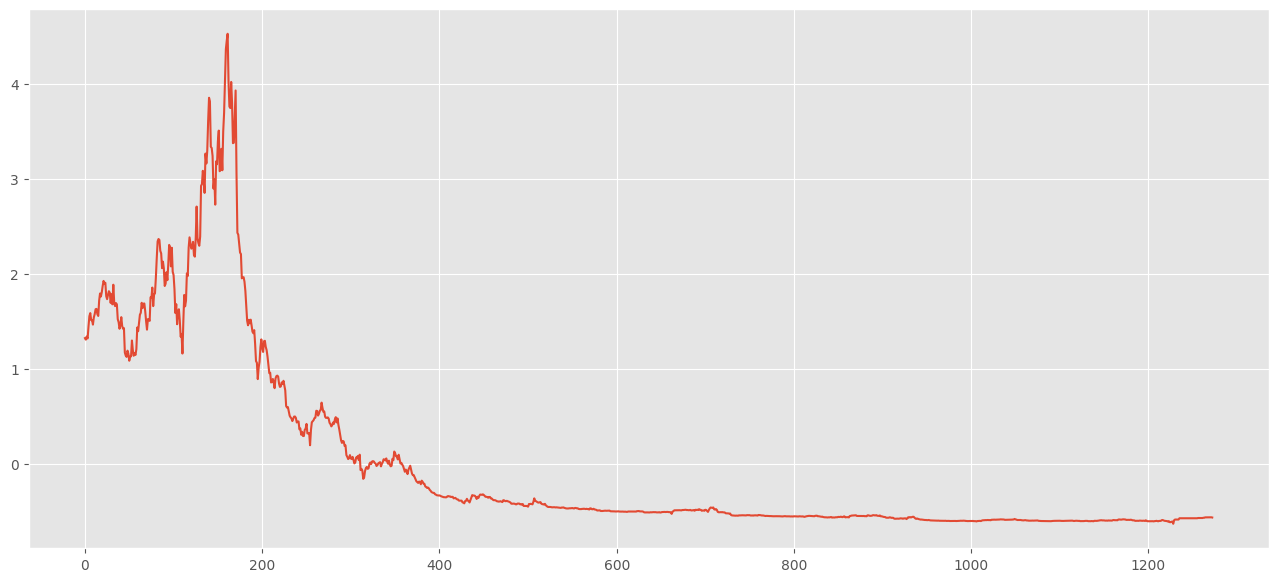

In [32]:
plt.figure(figsize=(16, 7))
plt.plot(data, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Price')
plt.grid()
plt.show()


# GRU 

 IMPLEMENTING GRU IN TENSORFLOW
 

In [33]:

vocab_size = 10 
hidden_size = 256
init = tf.initializers.glorot_uniform()

In [34]:

#Update gate weights
Uz = tf.Variable("Uz", [vocab_size, hidden_size], initializer=init)
Wz = tf.Variable("Wz", [hidden_size, hidden_size], initializer=init)
bz = tf.Variable("bz", [hidden_size], initializer=init)

In [35]:
#Reset gate weights
Ur = tf.Variable("Ur", [vocab_size, hidden_size], initializer=init)
Wr = tf.Variable("Wr", [hidden_size, hidden_size], initializer=init)
br = tf.Variable("br", [hidden_size], initializer=init)

In [36]:
# Content State weights

Uc = tf.Variable("Uc", [vocab_size, hidden_size], initializer=init)
Wc = tf.Variable("Wc", [hidden_size, hidden_size], initializer=init)
bc = tf.Variable("bc", [hidden_size], initializer=init)

In [37]:
# Output layer weights
V = tf.Variable("V", [hidden_size, vocab_size], initializer=init)
by = tf.Variable("by", [vocab_size], initializer=init)

In [ ]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

x_t = tf.compat.v1.placeholder(tf.float32, [batch_size, vocab_size])
h_t = tf.compat.v1.get_variable("h_t", [batch_size, hidden_size], initializer=init)

zt = tf.sigmoid(tf.matmul(x_t, Uz) + tf.matmul(h_t, Wz) + bz)
rt = tf.sigmoid(tf.matmul(x_t, Ur) + tf.matmul(h_t, Wr) + br)
ct = tf.tanh(tf.matmul(x_t, Uc) + tf.matmul(tf.multiply(rt, h_t), Wc) + bc)
h_t = tf.multiply((1 - zt), ct) + tf.multiply(zt, h_t)
y_hat_t = tf.matmul(h_t, V) + by


# bidirectional RNN


In [51]:
from tensorflow.compat.v1.nn import rnn_cell, static_bidirectional_rnn
num_hidden = 7

In [ ]:

forward_hidden_layer = rnn_cell.LSTMCell(num_hidden, forget_bias=1.0)

backward_hidden_layer = rnn_cell.LSTMCell(num_hidden, forget_bias=1.0)

outputs, forward_states, backward_states = rnn_cell.static_bidirectional_rnn(forward_hidden_layer, backward_hidden_layer, input)